# Proyecto para evaluar las distintas técnicas de balanceo que comunmente se utilizan

### Importamos librerías y módulos

In [1]:
from minisom import MiniSom 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import GEMA
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.pipeline import *
from src import workflow as wf
from src import funcionesCarlos as functions

2022-09-21 13:09:35.341863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 13:09:35.513542: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 13:09:36.068502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-21 13:09:36.068610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

El error que se produce en la representación de GEMA es cosa de la librería pero no impide seguir ejecutando las cosas. TAmbién es posible ver como se ha representado osea que no influye en nada

In [2]:
### ESTE CÓDIGO RECARGA LOS MÓDULOS/LIBRERÍAS CARGADOS ANTES DE CADA EJECUCIÓN, DE TAL FORMA QUE PODEMOS CAMBIAR
### UNA FUNCIÓN NUESTRA EN MITAD DE LA EJECUCIÓN Y DICHOS CAMBIOS SE EFECTUARÁN 
### ESTO ES ÚTIL CUANDO AÚN SE ESTÁ EN FASE DE DESARROLLO Y HAY QUE VERIFICAR SI LAS FUNCIONES TIENEN
### EL COMPORTAMIENTO DESEADO

%reload_ext autoreload

%autoreload 2

## Importamos el dataset del oil spill, que contiene datos de distintas imágenes de satélites. En una minoría de las imágenes tendremos un derrame de petróleo, y en la gran mayoría no. Tenemos un problema de clasificación binaria desbalanceado

## Detection of Oil Spills in Satellite Radar Images

In [3]:
## En el libro "Imbalanced Classification with Python" nos proporcionan el dataset en la siguiente URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv'
## Usaremos ese csv por tanto como nuestro dataframe
DF_oil_spill_bruto = pd.read_csv(url, header=None)

In [4]:
### COMPROBAMOS LA CARGA DEL DATA FRAME
DF_oil_spill_bruto

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,...,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,200,12,92.42,364.42,135,97200.0,59.42,10.34,884.0,0.17,...,381.84,254.56,84.85,146.97,4.50,0,2593.50,65.85,6.39,0
933,201,11,98.82,248.64,159,89100.0,59.64,10.18,831.0,0.17,...,284.60,180.00,150.00,51.96,1.90,0,4361.25,65.70,6.53,0
934,202,14,25.14,428.86,24,113400.0,60.14,17.94,847.0,0.30,...,402.49,180.00,180.00,0.00,2.24,0,2153.05,65.91,6.12,0
935,203,10,96.00,451.30,68,81000.0,59.90,15.01,831.0,0.25,...,402.49,180.00,90.00,73.48,4.47,0,2421.43,65.97,6.32,0


### La última columna (49) nos indica si la imagen contenía un derrame de petróleo (1), o no (0)

In [5]:
# Obtenemos el número total de filas y columnas de nuestro DataFrame
numero_filas = DF_oil_spill_bruto.shape[0]
numero_columnas = DF_oil_spill_bruto.shape[1]

print("\nNumero de filas total de nuestro dataframe: " + str(numero_filas))
lista_columnas=list(DF_oil_spill_bruto.columns)
cont=0

while cont<numero_columnas:  
    # Vamos a hacer un recuento de la cantidad de datos (NaN) vacíos que cotiene cada columna para ver cual no sería relevante
    numero=DF_oil_spill_bruto.iloc[:,cont].isna().sum()
    print("\nNumero de nans en la columna "+str(lista_columnas[cont])+": " + str(numero))
    print("En total un %"+str(round(numero/numero_filas*100,2))+" de filas NO tienen el dato de la columna.")    
    cont+=1


Numero de filas total de nuestro dataframe: 937

Numero de nans en la columna 0: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 1: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 2: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 3: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 4: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 5: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 6: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 7: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 8: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de nans en la columna 9: 0
En total un %0.0 de filas NO tienen el dato de la columna.

Numero de 

## Hemos comprobado que en este dataset proporcionado, no tenemos ningún dato faltante

## Vamos a comprobar la disparidad entre los dos tipos de datos de este dataset

In [6]:
# La columna 49 es la que indica el tipo de dato que es, o bien '1', o bien '0'
# Obersvaremos como efectivamente es un dataset binario, con dos clases
DF_oil_spill_bruto[49].value_counts()

0    896
1     41
Name: 49, dtype: int64

## Tenemos 896 items del tipo 0, que indica que no es una mancha de petróleo, por 41 del tipo 1, que indica un derrame de petróleo

## Vamos a quitar ahora las etiquetas de las imágenes del data frame, es decir, quitaremos la última columna, ya que necesitamos los datos sin etiquetar para entrenar el SOM
## También normalizaremos los datos mediante la técnica MinMax

In [7]:

### Quitamos la columna 49, que indica la clase, 0 -> no hay derrame, 1 -> hay derrame
DF_oil_spill_sin_etiqueta = DF_oil_spill_bruto.drop(columns = [49])


## Obtenemos las etiquetas
oil_spill_target = DF_oil_spill_bruto[49].values

### Vamos a normalizar los datos
DF_oil_spill_sin_etiqueta = functions.min_max(DF_oil_spill_sin_etiqueta)

DF_oil_spill_sin_etiqueta


,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.000000,0.078693,0.795369,0.167291,0.500000,0.088774,0.319870,0.295893,0.181873,0.236111,...,0.638298,0.238507,0.086957,0.079550,0.077489,0.048675,0.0,0.587669,0.976721,0.222222
1,0.002849,0.689181,0.040816,0.308430,1.000000,0.782405,0.486482,0.015926,0.382532,0.000000,...,0.638298,0.481199,1.000000,1.000000,0.943179,0.007830,0.0,0.932995,0.976393,0.046729
2,0.005698,0.003243,0.765631,0.223027,0.488889,0.003048,0.312378,0.272842,0.016699,0.222222,...,0.638298,0.117161,0.021739,0.015636,0.025816,0.121754,1.0,0.558460,0.979016,0.210800
3,0.008547,0.036783,0.825213,0.108185,0.366667,0.041157,0.344625,0.299246,0.108469,0.236111,...,0.638298,0.505595,0.066224,0.047241,0.082929,0.173953,1.0,0.671567,0.974426,0.234683
4,0.011396,0.009327,0.501465,0.161501,0.205556,0.009961,0.328827,0.259849,0.016761,0.208333,...,0.638298,0.110470,0.061794,0.053426,0.062444,0.033668,0.0,0.508444,0.974098,0.159917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,0.566952,0.000062,0.047854,0.133435,0.750000,0.000377,0.621824,0.398575,0.001356,0.208333,...,0.234043,0.031955,0.022136,0.008845,0.084073,0.058724,0.0,0.010212,0.980328,0.060228
933,0.569801,0.000031,0.051238,0.090925,0.883333,0.000264,0.625407,0.391869,0.001025,0.208333,...,0.234043,0.023817,0.015652,0.015636,0.029723,0.024794,0.0,0.043517,0.975410,0.074766
934,0.572650,0.000124,0.012278,0.157095,0.133333,0.000605,0.633550,0.717100,0.001124,0.388889,...,0.234043,0.033683,0.015652,0.018763,0.000000,0.029231,0.0,0.001913,0.982295,0.032191
935,0.575499,0.000000,0.049747,0.165334,0.377778,0.000150,0.629642,0.594300,0.001025,0.319444,...,0.234043,0.033683,0.015652,0.009381,0.042033,0.058332,0.0,0.006970,0.984262,0.052960


### Vamos a pasar el data frame a numpy array que es el tipo de dato que admite la SOM para entrenarse

In [8]:
# La abreviatura "SE" significa "sin etiquetar"

array_oil_spill_SE=DF_oil_spill_sin_etiqueta.to_numpy()


# Confirmamos que la transformación se ha efectuado correctamente
print("El número de datos del array es "+str(array_oil_spill_SE.shape[0])+ ", con una dimensionalidad de "+str(array_oil_spill_SE.shape[1]))


El número de datos del array es 937, con una dimensionalidad de 49


## Entrenamiento de SOM

### Vamos a realizar un grid search para encontrar los hiperparámetros óptimos

In [9]:
### Estos hiperparámetros son fijos y no van a cambiar en el grid search

n_neurons = 12
m_neurons = 12
dimensionalidad_datos = array_oil_spill_SE.shape[1]
semilla=34

In [10]:


mejor_error_topologico = 9
mejor_error_cuantificacion = 9

params_ganador_topologico = {'sigma':123,'learning_rate':5.5}
errores_ganador_topologico = {'error_cuantificación':12,'error_topológico':12}

params_ganador_cuantificacion = {'sigma':123,'learning_rate':5.5}
errores_ganador_cuantificacion = {'error_cuantificación':12,'error_topológico':12}

for p in functions.params_grid_search_petroleo:
    som = MiniSom(n_neurons, m_neurons, dimensionalidad_datos, sigma=p['sigma'],learning_rate=p['learning_rate'],random_seed=semilla)
    som.train(array_oil_spill_SE, num_iteration=6000, verbose=False)  # random training
    print("--------------------------------------------------------------------------------")
    print("Imprimiendo el error de la red con sigma="+str(p['sigma'])+" y learning rate="+str(p['learning_rate']))
    
    error_topologico=som.topographic_error(array_oil_spill_SE)
    error_cuantificacion=som.quantization_error(array_oil_spill_SE)
    print("Error topologico:",str(error_topologico))
    print("Error cuantificacion:"+ str(error_cuantificacion))
    if(error_topologico < mejor_error_topologico):
        mejor_error_topologico = error_topologico
        params_ganador_topologico = p
        errores_ganador_topologico['error_cuantificación']=error_cuantificacion
        errores_ganador_topologico['error_topológico']=error_topologico 
        
    if(error_cuantificacion < mejor_error_cuantificacion):
        mejor_error_cuantificacion = error_cuantificacion
        params_ganador_cuantificacion = p
        errores_ganador_cuantificacion['error_cuantificación']=error_cuantificacion
        errores_ganador_cuantificacion['error_topológico']=error_topologico 

print("--------------------------------------------------------------------------------")
print("--------------------------------------------------------------------------------")
print("-----------------------RESULTADOS-----------------------------------------------")
print("--------------------------------------------------------------------------------")
print("--------------------------------------------------------------------------------")
print("Los hiperparámetros que mejor error de cuantificación han dado son: "+str(params_ganador_cuantificacion))
print("Consiguiendo un error de cuantificación de "+str(mejor_error_cuantificacion))
print("Los errores totales de esta combinación son "+str(errores_ganador_cuantificacion))
print("\n\nLos hiperparámetros que mejor error topológico han dado son: "+str(params_ganador_topologico))
print("Consiguiendo un error topológico de "+str(mejor_error_topologico))
print("Los errores totales de esta combinación son "+str(errores_ganador_topologico))
print("--------------------------------------------------------------------------------")

--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=1 y learning rate=0.01
Error topologico: 0.007470651013874066
Error cuantificacion:0.6313766825958819
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=2 y learning rate=0.01
Error topologico: 0.0192102454642476
Error cuantificacion:0.603477881993658
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=3 y learning rate=0.01
Error topologico: 0.016008537886873
Error cuantificacion:0.5938618156808868
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=4 y learning rate=0.01
Error topologico: 0.004268943436499467
Error cuantificacion:0.6063773647439618
--------------------------------------------------------------------------------
Imprimiendo el error de la re

--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=2 y learning rate=0.5
Error topologico: 0.0768409818569904
Error cuantificacion:0.4358045675208936
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=3 y learning rate=0.5
Error topologico: 0.06510138740661686
Error cuantificacion:0.5232255976550131
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=4 y learning rate=0.5
Error topologico: 0.0768409818569904
Error cuantificacion:0.6130509717128
--------------------------------------------------------------------------------
Imprimiendo el error de la red con sigma=5 y learning rate=0.5
Error topologico: 0.13874066168623267
Error cuantificacion:0.8388317490078891
--------------------------------------------------------------------------------
Imprimiendo el error de la red con s

# -------------------------------------------------------------------------------
# PRIMERO PRIORIZANDO ERROR DE CUANTIFICACIÓN
# -------------------------------------------------------------------------------

## Vamos a probar la red con el error de cuantificación más bajo

In [11]:

som_cuantificacion = MiniSom(n_neurons, m_neurons,  dimensionalidad_datos, sigma=params_ganador_cuantificacion['sigma'],learning_rate=params_ganador_cuantificacion['learning_rate'],random_seed=semilla)
som_cuantificacion.train(array_oil_spill_SE, num_iteration=6000, verbose=True)  # random training
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))


 [  577 / 6000 ]  10% - 0:00:01 left 

 [  972 / 6000 ]  16% - 0:00:01 left 

 [ 1753 / 6000 ]  29% - 0:00:00 left 

 [ 2061 / 6000 ]  34% - 0:00:00 left 

 [ 2870 / 6000 ]  48% - 0:00:00 left 

 [ 3268 / 6000 ]  54% - 0:00:00 left 

 [ 4058 / 6000 ]  68% - 0:00:00 left 

 [ 4451 / 6000 ]  74% - 0:00:00 left 

 [ 5246 / 6000 ]  87% - 0:00:00 left 

 [ 5664 / 6000 ]  94% - 0:00:00 left 

 [ 6000 / 6000 ] 100% - 0:00:00 left 
 quantization error: 0.35644287514540923
Topological error: 0.23265741728922093


## Mapa de distancias de las neuronas, indicando también qué neurona ha reconocido a cada clase (puede haber una neurona que identifique ítems de ambas clases)

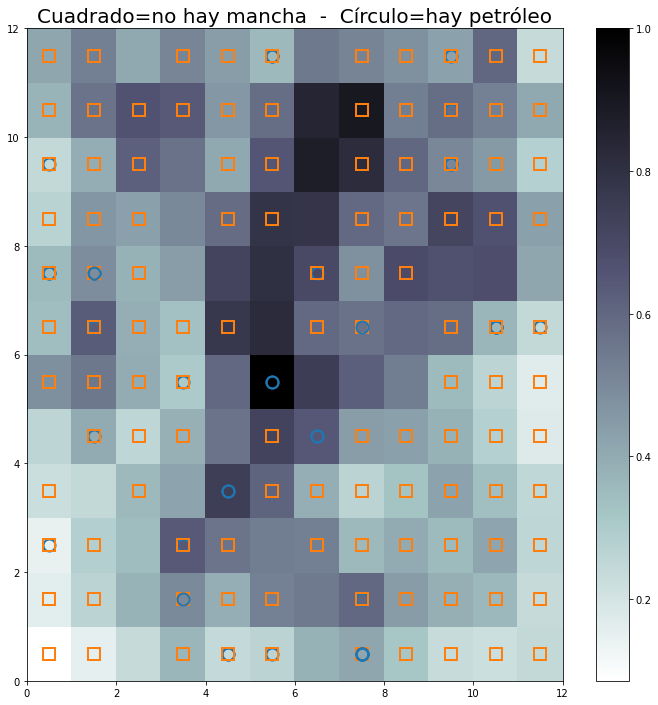

In [12]:

   
plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

#Greys
plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(array_oil_spill_SE):
    w = som_cuantificacion.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[oil_spill_target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[oil_spill_target[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos, donde cada punto es un ítem de nuestro dataset

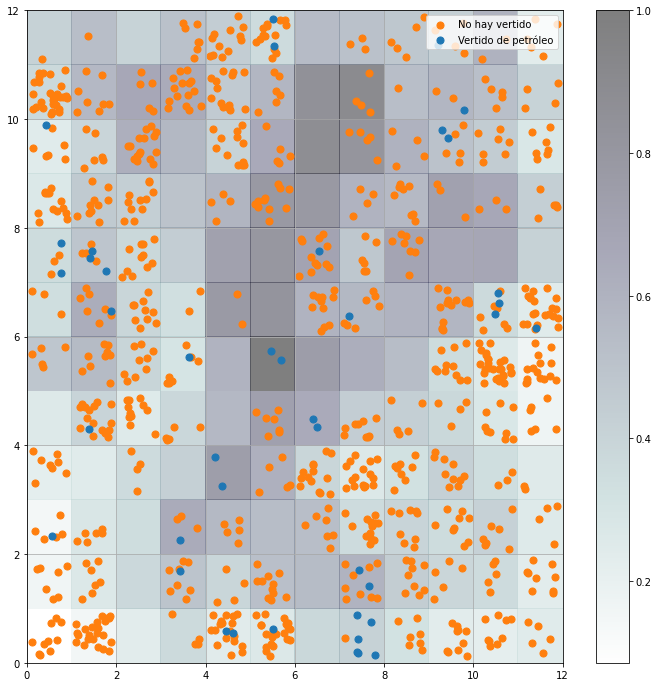

In [13]:
label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_cuantificacion.winner(d) for d in array_oil_spill_SE])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_cuantificacion.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(oil_spill_target):
    idx_target = oil_spill_target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# -------------------------------------------------------------------------------
# SEGUNDO PRIORIZANDO ERROR TOPOLÓGICO
# -------------------------------------------------------------------------------

## Vamos a probar la red con el error topológico más bajo

In [14]:

som_topologico = MiniSom(n_neurons, m_neurons,  dimensionalidad_datos, sigma=params_ganador_topologico['sigma'],learning_rate=params_ganador_topologico['learning_rate'],random_seed=semilla)
som_topologico.train(array_oil_spill_SE, num_iteration=6000, verbose=True)  # random training
print("Topological error:",som_topologico.topographic_error(array_oil_spill_SE))


 [ 1226 / 6000 ]  20% - 0:00:00 left 

 [ 2395 / 6000 ]  40% - 0:00:00 left 

 [ 3595 / 6000 ]  60% - 0:00:00 left 

 [ 4803 / 6000 ]  80% - 0:00:00 left 

 [ 5958 / 6000 ]  99% - 0:00:00 left 

 [ 6000 / 6000 ] 100% - 0:00:00 left 
 quantization error: 0.6425194705682868
Topological error: 0.0


## Mapa de distancias de las neuronas, indicando también qué neurona ha reconocido a cada clase (puede haber una neurona que identifique ítems de ambas clases)

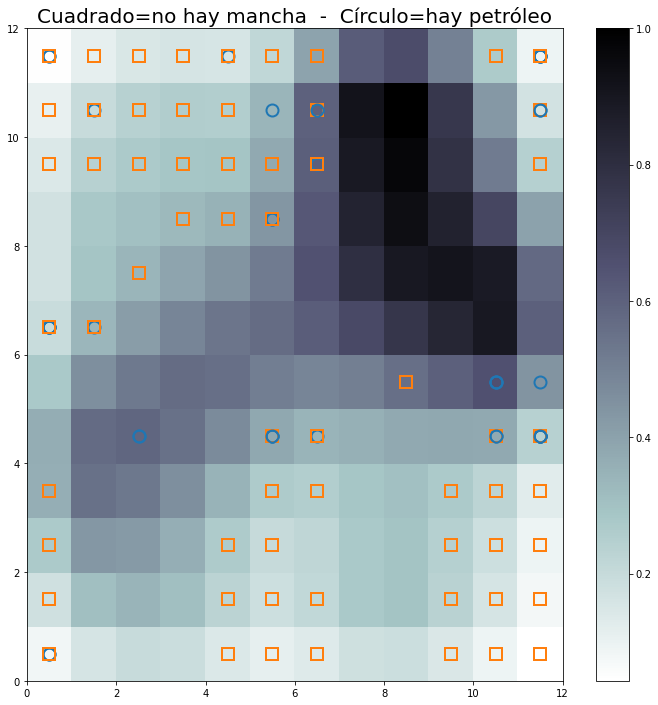

In [15]:

   
plt.figure(figsize=(n_neurons, m_neurons))

label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

#Greys
plt.pcolor(som_topologico.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()


# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['C0', 'C1']
for cnt, xx in enumerate(array_oil_spill_SE):
    w = som_topologico.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[oil_spill_target[cnt]-1], markerfacecolor='None',
             markeredgecolor=colors[oil_spill_target[cnt]-1], markersize=12, markeredgewidth=2)


plt.title("Cuadrado=no hay mancha  -  Círculo=hay petróleo",fontsize = 20)
plt.show()

## Mapa de puntos, donde cada punto es un ítem de nuestro dataset

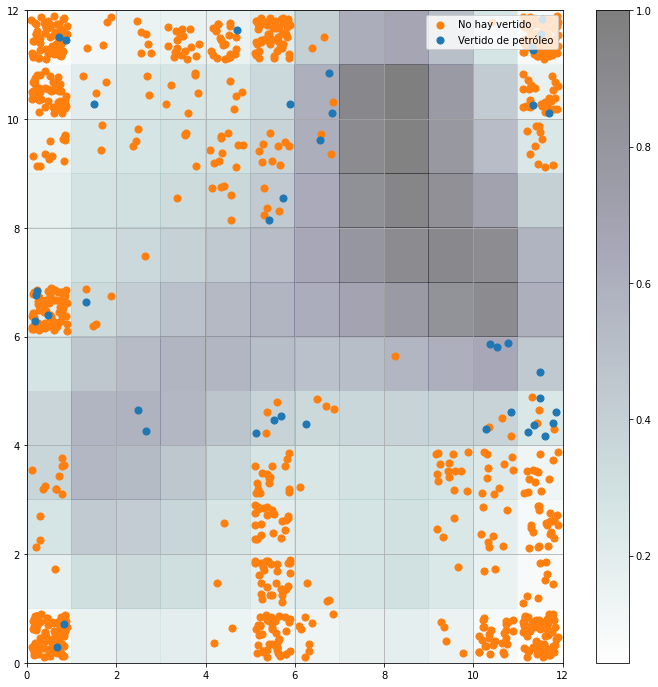

In [16]:
label_names = {0:'No hay vertido', 1:'Vertido de petróleo'}

plt.figure(figsize=(n_neurons, m_neurons))

w_x, w_y = zip(*[som_topologico.winner(d) for d in array_oil_spill_SE])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.pcolor(som_topologico.distance_map().T, cmap='bone_r', alpha=.5)
plt.colorbar()

for c in np.unique(oil_spill_target):
    idx_target = oil_spill_target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Generación de datos sintéticos mediante técnicas de undersampling y oversampling

## Vamos a generar datos sintéticos usando la librería "Imbalanced Learn", que nos brinda todos los algoritmos de undersampling y oversampling que necesitaremos. Usaremos a su vez un método que nos brinda la librería para combinar una técnica de undersampling junto con una de oversampling.

## Usaremos los siguientes algoritmos para realizar oversampling:         
###        ◦ SMOTE
###        ◦ ADASYN
###        ◦ Borderline SMOTE
###        ◦ SVM SMOTE
###        ◦ Kmeans SMOTE

## Usaremos los siguientes algoritmos para realizar undersampling:         
###        ◦ Tomek Links
###        ◦ Edited Nearest Neighbors
###        ◦ Condensed Nearest Neighbors
###        ◦ Neighbourhood Cleaning Rule
###        ◦ One Side Selection

## ------------------------------------------------------------

## SMOTE: combinaciones con undersampling y errores

In [17]:
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection
## 

array_X,array_y=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"SMOTE")

### Vamos a probar nuestra funcion de error
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))

functions.SOM_errores(som_cuantificacion,array_X,"SMOTE")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923


ERROR de SMOTE y Tomek Links:
Topological error: 0.30078125
Quantization error: 0.40071269289822


ERROR de SMOTE y Edited Nearest Neighbors:
Topological error: 0.3052455357142857
Quantization error: 0.39900321453021087


ERROR de SMOTE y Condensed Nearest Neighbors:
Topological error: 0.2318840579710145
Quantization error: 0.3517681328193008


ERROR de SMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.28292410714285715
Quantization error: 0.4009417781185909


ERROR de SMOTE y One Side Selection:
Topological error: 0.23214285714285715
Quantization error: 0.3516740689000318


## ------------------------------------------------------------

## ADASYN: combinaciones con undersampling y errores

In [18]:
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection

array_X,array_y=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"ADASYN")

### Vamos a probar nuestra funcion de error
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))

functions.SOM_errores(som_cuantificacion,array_X,"ADASYN")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923


ERROR de ADASYN y Tomek Links:
Topological error: 0.2717149220489978
Quantization error: 0.4006060489560427


ERROR de ADASYN y Edited Nearest Neighbors:
Topological error: 0.2750556792873051
Quantization error: 0.4006127142518692


ERROR de ADASYN y Condensed Nearest Neighbors:
Topological error: 0.2367303609341826
Quantization error: 0.3560057388734358


ERROR de ADASYN y Neighbourhood Cleaning Rule:
Topological error: 0.280022766078543
Quantization error: 0.40264578489209896


ERROR de ADASYN y One Side Selection:
Topological error: 0.27628635346756153
Quantization error: 0.40018284596696974


## ------------------------------------------------------------

## Borderline SMOTE: combinaciones con undersampling y errores

In [19]:
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection

array_X,array_y=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"BorderlineSMOTE")

### Vamos a probar nuestra funcion de error
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))

functions.SOM_errores(som_cuantificacion,array_X,"BorderlineSMOTE")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923


ERROR de BorderlineSMOTE y Tomek Links:
Topological error: 0.30318257956448913
Quantization error: 0.4091568734366936


ERROR de BorderlineSMOTE y Edited Nearest Neighbors:
Topological error: 0.3016759776536313
Quantization error: 0.4093281536207324


ERROR de BorderlineSMOTE y Condensed Nearest Neighbors:
Topological error: 0.2318840579710145
Quantization error: 0.3518391902327106


ERROR de BorderlineSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.29441340782122905
Quantization error: 0.40800159057616503


ERROR de BorderlineSMOTE y One Side Selection:
Topological error: 0.2329988851727982
Quantization error: 0.3518368685338675


## ------------------------------------------------------------

## SVM SMOTE: combinaciones con undersampling y errores

In [20]:
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection

array_X,array_y=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"SVMSMOTE")

### Vamos a probar nuestra funcion de error
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))

functions.SOM_errores(som_cuantificacion,array_X,"SVMSMOTE")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923


ERROR de SVMSMOTE y Tomek Links:
Topological error: 0.45865921787709496
Quantization error: 0.41857589832722764


ERROR de SVMSMOTE y Edited Nearest Neighbors:
Topological error: 0.4518477043673012
Quantization error: 0.4234165534795985


ERROR de SVMSMOTE y Condensed Nearest Neighbors:
Topological error: 0.2329988851727982
Quantization error: 0.35182497106789057


ERROR de SVMSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.5027995520716685
Quantization error: 0.42400486567567425


ERROR de SVMSMOTE y One Side Selection:
Topological error: 0.23214285714285715
Quantization error: 0.3516740689000318


## ------------------------------------------------------------

## KMeans SMOTE: combinaciones con undersampling y errores

In [21]:
## El orden del array es:
## X_TomekLinks,X_EditedNearestNeighbours,X_CondensedNearestNeighbour,X_NeighbourhoodCleaningRule,X_OneSidedSelection

array_X,array_y=functions.overSampling_combinaciones(array_oil_spill_SE,oil_spill_target,"KMeansSMOTE")

### Vamos a probar nuestra funcion de error
print("ERROR DE LOS DATOS ORIGINALES:")
print("Topological error:",som_cuantificacion.topographic_error(array_oil_spill_SE))
print("Quantization error:",som_cuantificacion.quantization_error(array_oil_spill_SE))

functions.SOM_errores(som_cuantificacion,array_X,"KMeansSMOTE")

ERROR DE LOS DATOS ORIGINALES:
Topological error: 0.23265741728922093
Quantization error: 0.35644287514540923


ERROR de KMeansSMOTE y Tomek Links:
Topological error: 0.21096810296586457
Quantization error: 0.37499391486474587


ERROR de KMeansSMOTE y Edited Nearest Neighbors:
Topological error: 0.2636928289102202
Quantization error: 0.384158899230682


ERROR de KMeansSMOTE y Condensed Nearest Neighbors:
Topological error: 0.23010752688172043
Quantization error: 0.3554049128343732


ERROR de KMeansSMOTE y Neighbourhood Cleaning Rule:
Topological error: 0.18459796149490373
Quantization error: 0.38296315878743953


ERROR de KMeansSMOTE y One Side Selection:
Topological error: 0.2446500867553499
Quantization error: 0.3803686800956507
